In [1]:
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import gurobipy as gp

import numpy as np

from modelname.dataset import ServiceNetworkDataset

In [3]:
data = ServiceNetworkDataset()
data.nyc_neighborhoods.shape

(103,)

In [17]:
# Parameters
N_HUBS = 6

nodes = data.nyc_neighborhoods
N = np.arange(len(nodes))
distances = data.get_distances()  # from node i to node j
demands = data.get_demands()  # between node i and node j

In [22]:
model = gp.Model("Hub network")

MIN_DIST = 10

x = model.addVars(*N.shape, vtype=gp.GRB.BINARY, name="x")  # x_i
y = model.addVars(*distances.shape, vtype=gp.GRB.BINARY, name="y")  # y_i,j

# Objective: Minimize total distance
model.setObjective(
    gp.quicksum(
        y[i, j] * demands[i, j] / distances[i, j]
        for i in N
        for j in N
        if demands[i, j] > 0
    ),
    gp.GRB.MAXIMIZE,
)

# Constraint 1: Select exactly n_hubs
model.addConstr(x.sum() == N_HUBS, "Select_hubs")

# Constraint 2: Each location j must be assigned to one or no hub
model.addConstrs((y.sum("*", j) <= 1 for j in N), "Assign_each_location")

# Constraint 3: A location j can only be assigned to a hub i if i is selected as a hub
model.addConstrs((y[i, j] <= x[i] for i in N for j in N), "Assign_to_hub")

model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.1 LTS")

CPU model: Intel(R) Core(TM) i5-10500H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2594821 - for non-commercial use only - registered to oy___@tum.de
Optimize a model with 10713 rows, 10712 columns and 31930 nonzeros
Model fingerprint: 0x4e6b20a4
Variable types: 0 continuous, 10712 integer (10712 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 1655.5456532
Presolve removed 7135 rows and 7120 columns
Presolve time: 0.05s
Presolved: 3578 rows, 3592 columns, 10574 nonzeros
Variable types: 0 continuous, 3592 integer (3591 binary)

Root relaxation: objective 7.479685e+04, 443 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Ob

In [23]:
solution_hubs = []
for i in N:
    solution_hubs.append(x[i].X)
solution_hubs = np.array(solution_hubs)

solution_arcs = []
for i in N:
    solution_arc = []
    for j in N:
        solution_arc.append(y[i, j].X)
    solution_arcs.append(solution_arc)
solution_arcs = np.array(solution_arcs)

print(data.nyc_neighborhoods[solution_hubs.astype(np.bool)])
print(np.all(solution_arcs == 0))
# ['Castleton Corners' 'New Brighton' 'Oakwood' 'Prospect Heights' 'Red Hook']

['East Harlem' 'Fort Greene' 'Harlem' 'Midwood' 'Tottenville'
 'Upper West Side']
False


In [ ]:
data.visualize(list(data.nyc_neighborhoods[solution_hubs.astype(np.bool)]))

In [ ]:
data.visualize_solution(solution_arcs)

In [25]:
import pandas as pd

demand = data.df.groupby(
    ["pickup_neighbourhood", "dropoff_neighbourhood"], as_index=False
)["passenger_count"].sum()
demand = pd.DataFrame(demand)

In [39]:
demand[demand["pickup_neighbourhood"] == "Brownsville"]

,pickup_neighbourhood,dropoff_neighbourhood,passenger_count
590,Brownsville,Tottenville,4


Total demand via 25 to 12: 1.0
Total demand via 25 to 45: 1.0
Total demand via 25 to 58: 1.0
Total demand via 25 to 93: 1.0
Total demand via 25 to 94: 1.0
Total demand via 35 to 19: 1.0
Total demand via 35 to 21: 1.0
Total demand via 35 to 67: 1.0
Total demand via 35 to 70: 1.0
Total demand via 45 to 25: 1.0
Total demand via 45 to 47: 1.0
Total demand via 45 to 49: 1.0
Total demand via 56 to 1: 1.0
Total demand via 56 to 2: 1.0
Total demand via 56 to 3: 1.0
Total demand via 56 to 4: 1.0
Total demand via 56 to 5: 1.0
Total demand via 56 to 6: 1.0
Total demand via 56 to 7: 1.0
Total demand via 56 to 8: 1.0
Total demand via 56 to 9: 1.0
Total demand via 56 to 10: 1.0
Total demand via 56 to 13: 1.0
Total demand via 56 to 15: 1.0
Total demand via 56 to 18: 1.0
Total demand via 56 to 20: 1.0
Total demand via 56 to 22: 1.0
Total demand via 56 to 23: 1.0
Total demand via 56 to 24: 1.0
Total demand via 56 to 29: 1.0
Total demand via 56 to 30: 1.0
Total demand via 56 to 32: 1.0
Total demand via 

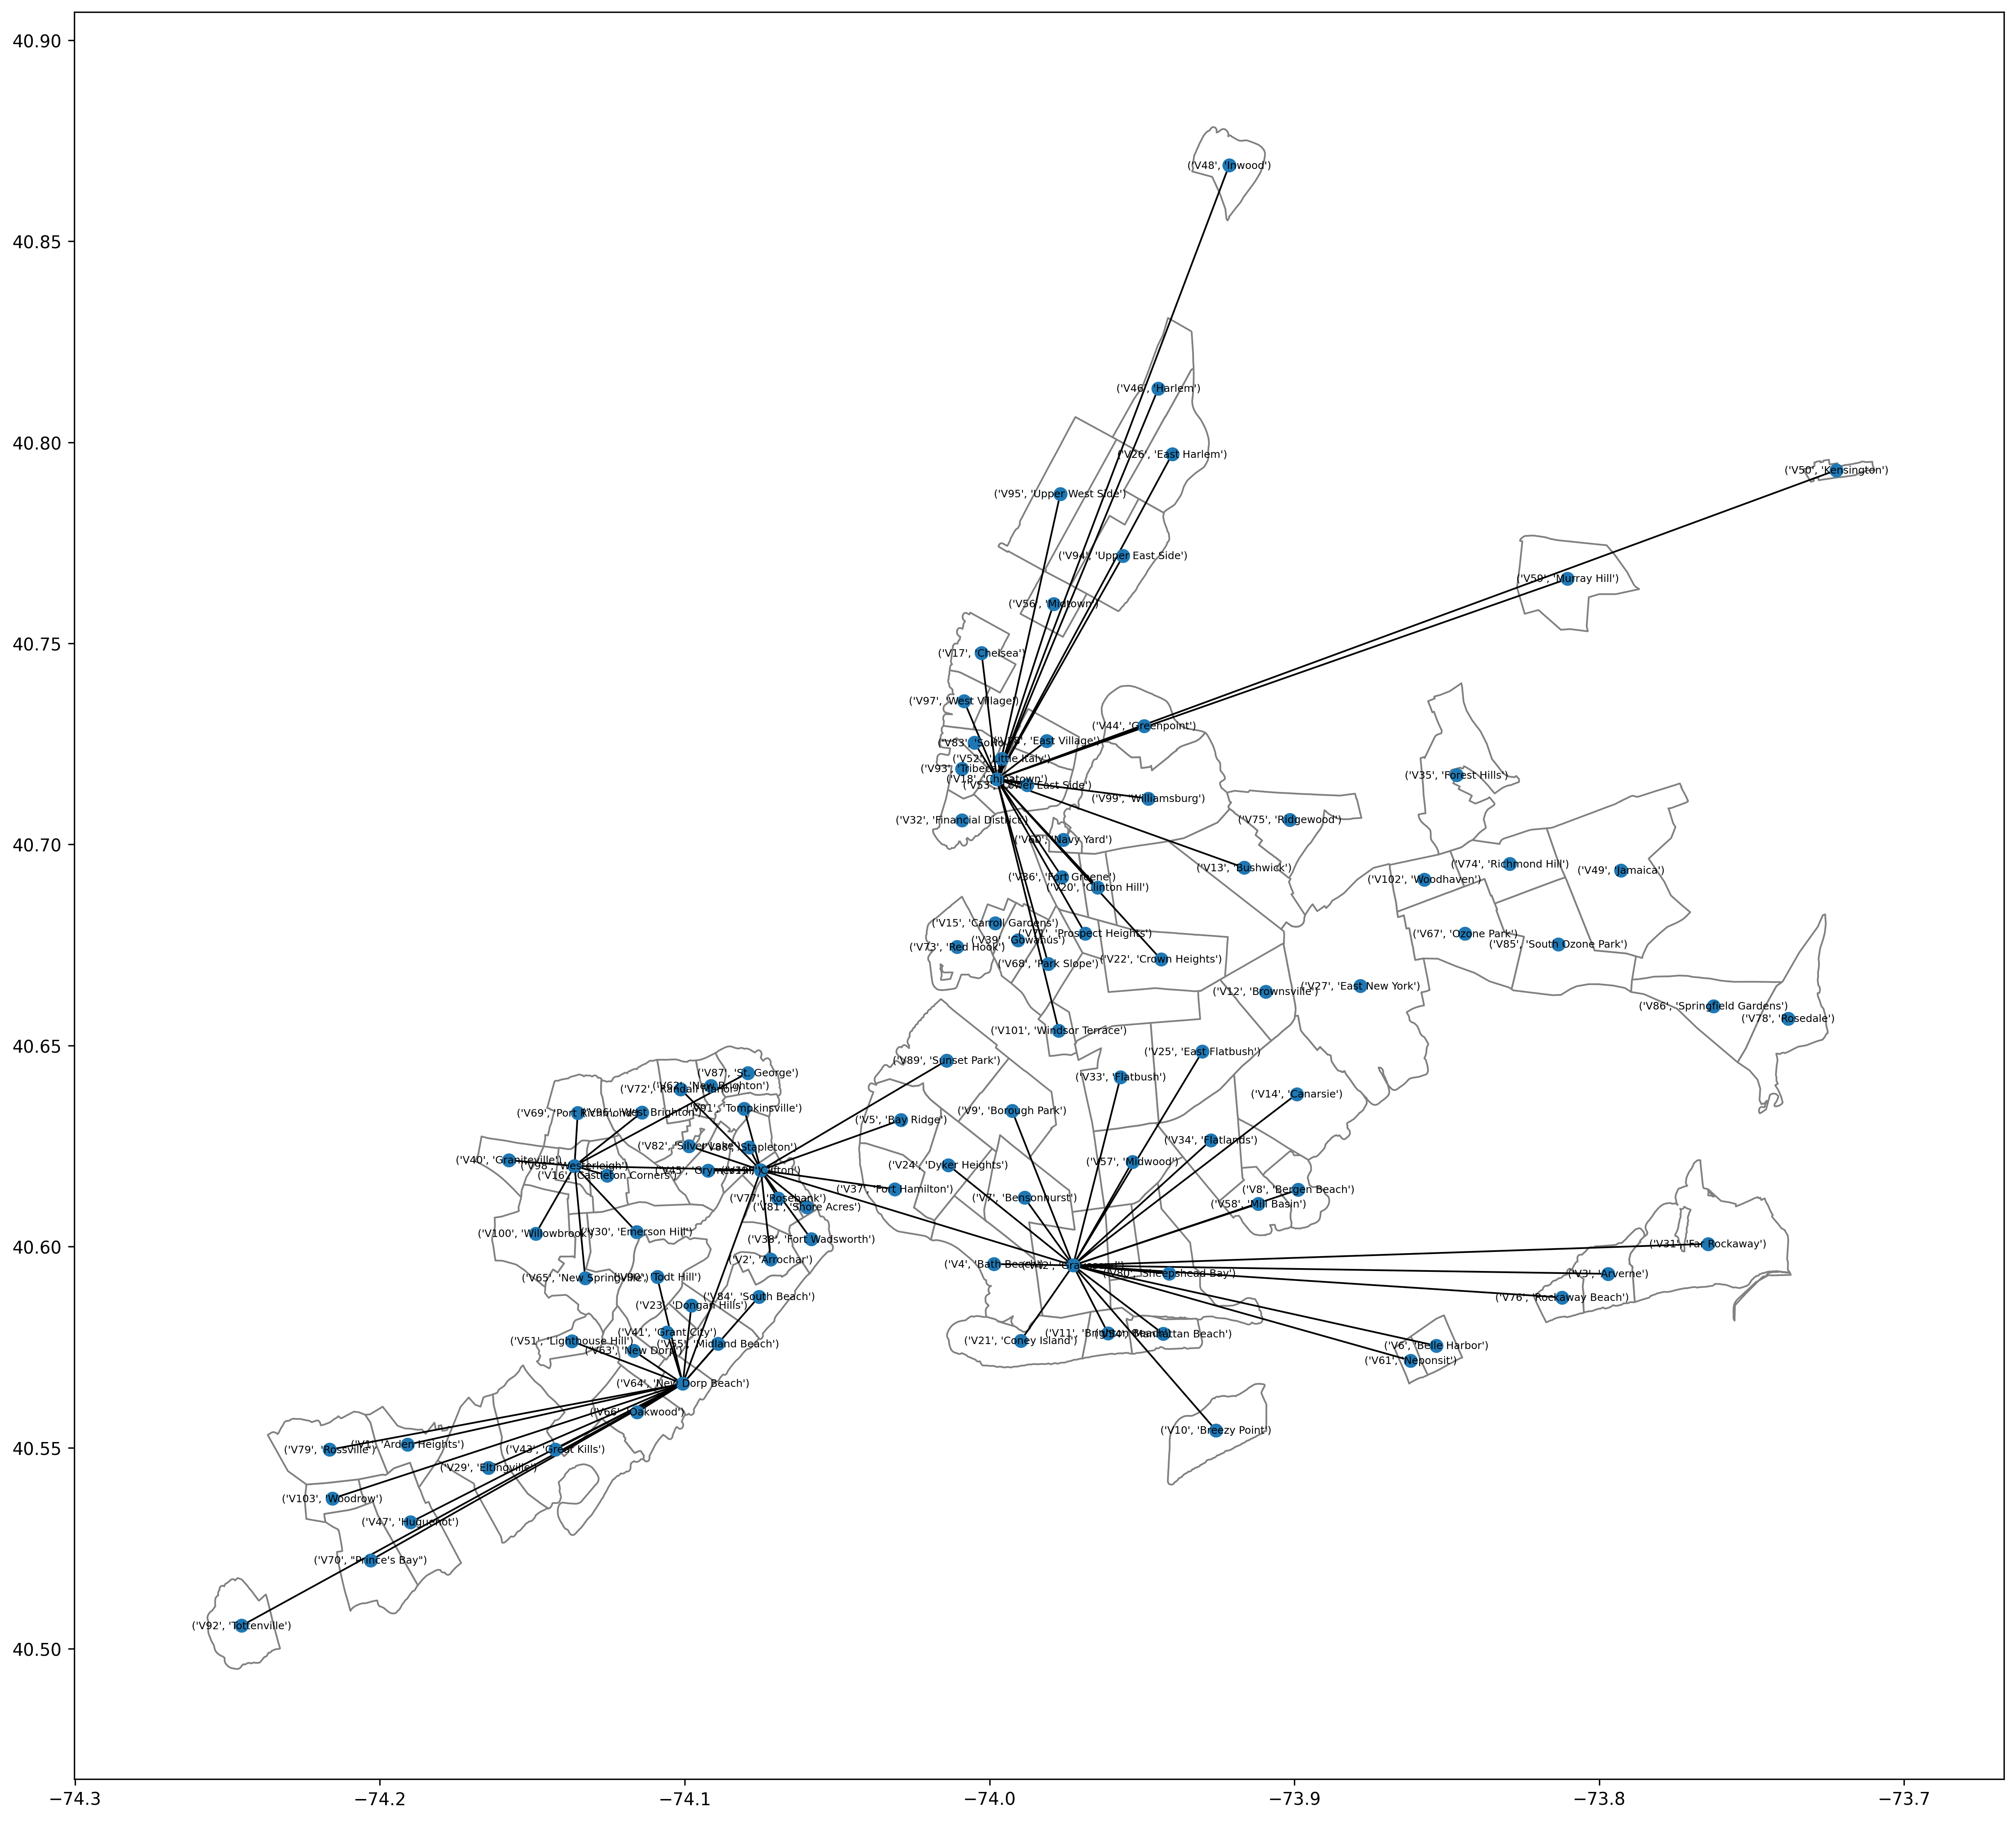

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

edges = data.create_edges(solution_arcs)
nodes = data.create_nodes()

graph = nx.Graph()
graph.add_nodes_from(data.get_nodes())
graph.add_edges_from(data.get_edges(solution_arcs))

fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=300)
data.nyc_map.plot(ax=ax, color="white", edgecolor="grey")

nx.draw_networkx(
    graph,
    pos=nodes,
    # node_color=nx.get_node_attributes(graph, "color").values(),
    ax=ax,
    hide_ticks=False,
    node_size=50,
    font_size=6,
)
plt.show()